# Gagana
This notebook is struted for code generation, using the single shot experiment vs the iterative mutation from Italiano and Cummins - regarding our limitations on colab and compilation, triying to have minimal modifies.
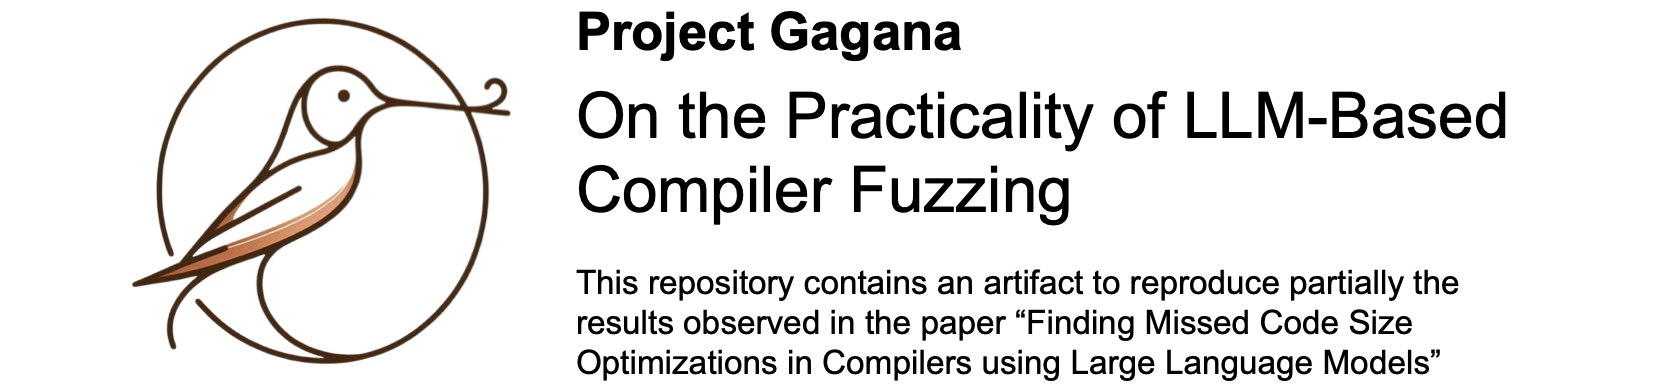

### Imports

In [ ]:
!pip install --upgrade transformers
!pip install transformers==4.46.0

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
) #the model

import torch #for the model

import numpy as np #to better use of the arrays

import time #measure time

import pandas as pd #for csv

import statsmodels.api as sm #for run stats
import seaborn as sns

from google.colab import drive #to import the csv and other data
from google.colab import auth
from google.colab import userdata

from googleapiclient.discovery import build #for auto-creation of the model folder in drive
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload, MediaFileUpload, MediaIoBaseUpload
import io  #
from io import BytesIO

from huggingface_hub import login #for login and run some of the models, some may require a auth key


import subprocess #for write file...
import random
import string
import os
import sys

In [ ]:
input_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/code_add.csv' #inputs data for any generation
parent_folder_name = '/content/drive/MyDrive/Colab_Notebooks/Baku/data' #is needed to define where the models folder gonna be - EX: /content/drive/MyDrive/Colab_Notebooks/Gagana/data
parent_folder_id = '1in8l0U27clRkArjjfzHlrb8i_K47Bq25' #the google drive id for the folder - EX : 1in8l0U27xxxxxxxxb8i_K47Bq25


drive.mount('/content/drive')# to mount drive for file search
auth.authenticate_user()

Mounted at /content/drive


In [ ]:
os.environ["colab_key_name"] = userdata.get("key_from_hugging_face") #only for LLAMA3 model's
login(os.environ["colab_key_name"])

### Classes

### Drive

In [ ]:
class Drive:

    @staticmethod
    def find_file(parent_folder_id: str, file_name: str): # using the drive service
        service = build('drive', 'v3')
        query = ( #query the file in the folder_id
          f"'{parent_folder_id}' in parents "
          f"and name = '{file_name}' "
          "and trashed = false"
        )

        resp = service.files().list(q=query, fields='files(id,name)').execute()
        files = resp.get('files', [])
        return files[0] if files else None

    @staticmethod
    def find_file_recursive(parent_folder_id, filename):#recursive search of the file
        service = build('drive', 'v3')
        result = Drive.find_file(parent_folder_id, filename)
        if result:
            return result

        query = f"'{parent_folder_id}' in parents and mimeType = 'application/vnd.google-apps.folder' and trashed = false"
        response = service.files().list(q=query, fields="files(id, name)").execute()
        folders = response.get('files', [])

        for folder in folders: #children folders
            result = Drive.find_file(folder['id'], filename)
            if result:
                return result

        return None

    @staticmethod
    def read_file_content(file_id): #return the content in a file
        service = build('drive', 'v3')
        request = service.files().get_media(fileId=file_id)
        fh = BytesIO()
        
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        
        while not done:
            status, done = downloader.next_chunk()
        fh.seek(0)
        return fh.read().decode('utf-8')

    @staticmethod
    def upload_empty_csv(parent_folder_id: str, file_name: str):
        #creates/retrives the data csv from the code generation
        headers = {
            'model_single_programs.csv': ['model_name','seconds','code_name','caracteristcs','length'],
            'model_chain_programs.csv': ['model_name', 'seconds', 'code_name', 'characteristics', 'length', 'previous_code', 'folder_id'],
            'chains.csv': ['folder_id', 'num_programs', 'time_spent', 'mean_time_program', 'compilation', 'model_name']
        }
        
        df = pd.DataFrame(columns=headers.get(file_name, []))
        fh = BytesIO()
        df.to_csv(fh, index=False)
        fh.seek(0)
        
        service = build('drive', 'v3')
        media = MediaIoBaseUpload(fh, mimetype='text/csv') #create the CSV with the columns, just for init settings
        service.files().create(
            body={'name': file_name, 'parents': [parent_folder_id]},
            media_body=media,
            fields='id'
        ).execute()


    @staticmethod
    def upload_and_get_file(parent_folder_id, local_path, upload_name): #upload a file and return its id/name for another uses
        file_metadata = {'name': upload_name, 'parents': [parent_folder_id]}
        media = MediaFileUpload(local_path, mimetype='text/csv')
        service = build('drive', 'v3')
        
        created = service.files().create(
            body=file_metadata, media_body=media, fields='id'
        ).execute()
        
        return Drive.find_file(parent_folder_id, upload_name)

    @staticmethod
    def upload_single_file_to_drive(folder_id,code_name,program):#Upload single file generation to drive for colab
        try:
            local_file_path = f"/content/{code_name}.c"


            with open(local_file_path, "w") as file:
                file.write(program)


            file_metadata = {
                'name': f'{code_name}.c',
                'parents': [folder_id]
            }

            media = MediaFileUpload(local_file_path, mimetype='text/plain')
            service = build('drive', 'v3')
            uploaded_file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()

            print(f"File uploaded successfully. File ID: {uploaded_file.get('id')}")
        except Exception as e:
            print(f"File could not be uploaded. ERROR: {e}")

    @staticmethod
    def upload_chain_file_to_drive(program,folder_id,folder_name,n):#Upload on going chain file (iterative mutation) generation to drive for colab
        try:
            local_file_path = f"/content/{folder_name}{n}.c"


            with open(local_file_path, "w") as file:
                file.write(program)


            file_metadata = {
                'name': f'{folder_name}{n}.c',
                'parents': [folder_id]
            }

            media = MediaFileUpload(local_file_path, mimetype='text/plain')
            service = build('drive', 'v3')
            uploaded_file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()

            print(f"File uploaded successfully. File ID: {uploaded_file.get('id')}")
        except Exception as e:
            print(f"File could not be uploaded. ERROR: {e}")

    @staticmethod
    def folder_generator(folder_data,parent_folder_id,size=4): #create a folder with random name, used for iterative mutation
        try:
            chars=string.ascii_uppercase
            random_name = ''.join(random.choice(chars) for _ in range(size))
            while random_name in folder_data.column_values('folder_id'):
                random_name = ''.join(random.choice(chars) for _ in range(size))

            folder_metadata = {
                'name': random_name,
                'mimeType': 'application/vnd.google-apps.folder'
            }

            if parent_folder_id:
                folder_metadata['parents'] = [parent_folder_id]

            service = build('drive', 'v3')
            created_folder = service.files().create(
                body=folder_metadata,
                fields='id'
            ).execute()

            return created_folder.get('id'),random_name
        except Exception as e:
            raise f"Folder coulnd't been created: {e}"

    @staticmethod
    def find_folder(parent_folder_id: str, folder_name: str): #find a folder given its name and the aprent folder
        try:
            drive_service = build('drive', 'v3')

            query = f"'{parent_folder_id}' in parents and name = '{folder_name}' and mimeType = 'application/vnd.google-apps.folder'"

            results = drive_service.files().list(
                q=query,
                fields='files(id, name)'
            ).execute()

            folders = results.get('files', [])

            if folders:
                return folders[0]['id'], folders[0]['name']
            else:
                return None, None

        except Exception as e:
            raise f"Folder coulnd't been founded: {e}"


    @staticmethod
    def create_folder_model(parent_folder_id: str, folder_name: str):#create the folder that contains the model data
        try:
            drive_service = build('drive', 'v3')

            main_folder_metadata = {
                'name': folder_name,
                'mimeType': 'application/vnd.google-apps.folder'
            }

            if parent_folder_id:
                main_folder_metadata['parents'] = [parent_folder_id]

            main_folder = drive_service.files().create(
                body=main_folder_metadata,
                fields='id'
            ).execute()

            main_folder_id = main_folder.get('id')

            chain_metadata = {
                'name': 'chain',
                'mimeType': 'application/vnd.google-apps.folder',
                'parents': [main_folder_id]
            }

            chain_folder = drive_service.files().create(
                body=chain_metadata,
                fields='id'
            ).execute()

            singles_metadata = {
                'name': 'singles',
                'mimeType': 'application/vnd.google-apps.folder',
                'parents': [main_folder_id]
            }

            singles_folder = drive_service.files().create(
                body=singles_metadata,
                fields='id'
            ).execute()

            return main_folder_id, folder_name, singles_folder.get('id'),chain_folder.get('id')

        except Exception as e:
          raise RuntimeError(f"Folder couldn't be created: {e}")


#### DataLoader

In [ ]:
class DataLoader:
    def __init__(
        self,
        data_path: str = None,
        file_id: str = None,
        drive_service=None
    ):
        """
        Initialize DataLoader either from a local path or a Drive file ID.
        Pass an existing `drive_service = build('drive','v3')` if using file_id.
        """
        if file_id is None and data_path is None:
            raise ValueError("Either data_path or file_id must be provided.")

        # use Drive API when file_id is given
        if file_id:
            
            if drive_service is None:
                drive_service = build('drive', 'v3')
            request = drive_service.files().get_media(fileId=file_id)
            fh = BytesIO()
            downloader = MediaIoBaseDownload(fh, request)
            done = False
            
            while not done:
                status, done = downloader.next_chunk()
            fh.seek(0)
            
            
            self.dataframe = pd.read_csv(fh)#retrive the files and put on a dataframe
            self.source = {'file_id': file_id, 'drive_service': drive_service}
        else:
            self.data_path = data_path
            self.dataframe = pd.read_csv(data_path)
            self.source = {'data_path': data_path}

    def save(self):
        #save changes back to original source (local path or Drive).
        if 'data_path' in self.source:
            self.dataframe.to_csv(self.source['data_path'], index=False)
        else:
            file_id = self.source['file_id']
            service = self.source['drive_service']
            # write dataframe to BytesIO
            fh = BytesIO()
            self.dataframe.to_csv(fh, index=False)
            fh.seek(0)
            media = MediaIoBaseUpload(fh, mimetype='text/csv', resumable=True)
            service.files().update(
                fileId=file_id,
                media_body=media
            ).execute()

    def column_values(self,column_name):#get a list of values in a column
        try:
            return self.dataframe[column_name].values
        except:
            raise Exception("Column must be wrong.")

    def new_row(self, new_values: list):#matches two list to form a new data row
      if len(new_values) != len(self.dataframe.columns):
          raise ValueError("The number of values does not match the number of columns.")

      # create a DataFrame from the new row values
      new_row = pd.DataFrame([dict(zip(self.dataframe.columns, new_values))])

      self.dataframe = pd.concat([self.dataframe, new_row], ignore_index=True)

    def update_row(self,index: str, new_values:list):
        if len(new_values) != len(self.dataframe.columns):
            raise ValueError("The number of values does not match the number of columns.")
        self.dataframe = self.dataframe.set_index(index)
        self.dataframe.loc[new_values[0]] = new_values[1:]
        self.dataframe = self.dataframe.reset_index()


    def get_row(self, column: str, key: any):#get all row using a key
        row = self.dataframe.set_index(column).loc[[key]]  # [[key]] to ensure good research
        values = row.values.flatten().tolist()
        return values

    def static_row_string(self,id,ignore_columns=""):#chose a value to generate, used for tests
        if(id==0):
            return "Impossible to pick the value."

        else:

            if not ignore_columns == "": #if there is a column...
                static = self.dataframe.drop(ignore_columns, axis=1).iloc[id]

            else:
                static = self.dataframe.iloc[id]

            static = static.to_string(index=False)
            return static

    def random_row_string(self, ignore_columns=""):#chose a random value to generate, used for any generation on the paper
        random_row = self.dataframe.sample()
        id_value = random_row['id'].values[0]

        if ignore_columns:
            if isinstance(ignore_columns, str):
                ignore_columns = [ignore_columns]
            random_row = random_row.drop(ignore_columns, axis=1)

        random_row = random_row.drop('id', axis=1, errors='ignore')

        values = [str(val).replace('"', '').replace("'", '').strip()
                  for val in random_row.values[0]]
        result_string = ' '.join(values)

        return result_string.strip(), id_value




#### CodeGeneration

In [ ]:

class CodeGeneration:

    def __init__(self,model,model_name,tokenizer,data : DataLoader,input_str: str,input_id : int,
                 max_length : int, base_code: str,name_atr:str):
        self.model = model #model class
        self.model_name = model_name 
        self.data = data #data where the programs are register
        self.input_str = input_str #the input
        self.max_length = max_length # max length of generation, for arbitrary reasons, 2048 - we did not notice any program larger than this
        self.input_id = input_id 
        self.tokenizer = tokenizer 
        self.base_code = base_code #current seed
        self.name_atr = name_atr #for name generation

        #the template for extraction
        self.template = f"""
        Rewrite this code to {self.input_str}:
        {self.base_code}

        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            {self.base_code}
            </Program>
        """

        self.dif_seconds = 0
        self.ouput = ""
        self.program_name = ""
        self.program = ""


    def generate_code(self):#measure time and generate the code
        input_time = time.time()
        inputs = self.tokenizer(self.template, return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(**inputs, max_length=self.max_length) #model output
        output_time = time.time()

        self.dif_seconds = (output_time - input_time) #time measure
        decoded_output = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        self.output = decoded_output


    def get_output_list(self):#return the data from the program generation

        if self.program.strip() == self.base_code.strip() or len(self.program) <= len(self.base_code) + 10:
            return [self.model_name, self.dif_seconds, self.program_name, self.input_id, -1]

        len_program = len(self.tokenizer.encode(self.program)) #count the amount of tokens in the program
        return [self.model_name,
                self.dif_seconds,
                self.program_name,
                self.input_id,
                len_program]


    def program_extratcion(self):#return the program generated, just verifies if generate any program, do not verify correcteness of code
        self.name_generator()

        if self.program == "":
            final_program = ""
            suboutput_list = self.output.split("<Program>")#extract from the tags

            for subprogram in (suboutput_list):
              if "</Program>" in subprogram:
                program = subprogram.split("</Program>")[0]

                if program.count('{') == program.count('}'):
                        final_program = program

            self.program = final_program

        return self.program


    def name_generator(self,size=4): #randomly generate a new file name

        if self.program_name == "" :
            chars=string.ascii_uppercase + string.digits
            random_name = ''.join(random.choice(chars) for _ in range(size))
            while random_name in self.data.column_values(self.name_atr):
                random_name = ''.join(random.choice(chars) for _ in range(size))
            self.program_name = random_name




#### Generation Pipeline

In [ ]:

class GenerationPipeline:
    def __init__(
            self,
            model: object,
            model_name: str,
            tokenizer: object,
            input_data_path: str,
            parent_id: str,
            model_name_folder: str,
            parent_folder_name: str
        ):
        self.model = model
        self.model_name = model_name
        self.tokenizer = tokenizer
        self.input_data = DataLoader(input_data_path) #the input dataframe

        self.ignore_columns = ['id', 'type']
        self.drive_service = build('drive', 'v3')

        try: #crete the folder with the model data
            folder_id, folder_name= Drive.find_folder(parent_id, model_name_folder)

            if folder_id is None:
                folder_id, folder_name,single_folder_id,chain_folder_id = Drive.create_folder_model(parent_id, model_name_folder)
            else:
              single_folder_id, _ = Drive.find_folder(folder_id, 'singles')
              chain_folder_id, _ = Drive.find_folder(folder_id, 'chain')

            self.folder_id = folder_id
            self.single_folder_id = single_folder_id
            self.chain_folder_id = chain_folder_id

            csv_names = ['model_single_programs.csv', 'model_chain_programs.csv', 'chains.csv']
            loaders = []
            for name in csv_names: #load the model program generate data
                file = Drive.find_file(self.folder_id, name)
                if file is None:
                    Drive.upload_empty_csv(self.folder_id, name)
                    file = Drive.find_file(self.folder_id, name)
                loaders.append(DataLoader(file_id=file['id'], drive_service=self.drive_service))
            
            #single-shot, iterative mutation programs and iterative-mutation chains (the programs seqeuence for i.m)
            self.models_data, self.models_chain, self.chains_data = loaders

        except Exception as e:
            raise RuntimeError(f"ERRO on Pipeline creation: {e}")

    def single_code_generation(self, max_len: int, static: bool = False, id: int = 0):
        try: #run the single-shot code generation
            if static:
                input_value, input_id = self.input_data.static_row_string(id, self.ignore_columns)
            else:
                input_value, input_id = self.input_data.random_row_string(self.ignore_columns)#the random input

            base_code = """ int f(int a) {
                return 0;
                }"""

            generator = CodeGeneration(
                model=self.model,
                model_name=self.model_name,
                tokenizer=self.tokenizer,
                data=self.models_data,
                input_str=input_value,
                input_id=input_id,
                max_length=max_len,
                base_code=base_code,
                name_atr='code_name'
            )

            generator.generate_code()#generate
            program = generator.program_extratcion()
            output_list = generator.get_output_list()

            if output_list[4] > 0:#if actually generate a program
                Drive.upload_single_file_to_drive(self.single_folder_id, output_list[2], program) #go to drive

            self.models_data.new_row(output_list)#updates the data
            self.models_data.save()
            print("Program Generated!")
        except Exception as e:
            print(f"ERRO: {e}")

    def single_sampling(self, duration_hours=3):#single-shot test for any model
        current_max_length = 2048
        duration_seconds = duration_hours * 3600
        start_time = time.time()
        while (time.time() - start_time) < duration_seconds: #samples for 3 hours
            try:
                self.single_code_generation(current_max_length)
            except Exception as e:
                print(f"Critical Error: {e}")
        print(f"Sampling Done! Total samples: {duration_hours} hours")

    def chain_code_generation(self, max_len: int, n: int = 1): #a sequence for iterative mutation, aka chain
        try:#run the code generation
            ac_time = 0
            #start within this seed
            base_code = """ int f(int a) {
                    return 0;
                    }"""
            i = 0 #first chain program is 0
            last_code_id = ''
            folder_id, folder_name = Drive.folder_generator(self.chains_data, self.chain_folder_id) #generate the chain folder
            rows_chain = [folder_name, i, ac_time, ac_time/n, "False", self.model_name] #create the chain in the csv of chains, import constraint for unique names
            self.chains_data.new_row(rows_chain)
            self.chains_data.save()
            for _ in range(n):
                input_value, input_id = self.input_data.random_row_string(self.ignore_columns)# current random input
                
                generator = CodeGeneration(
                    model=self.model,
                    model_name=self.model_name,
                    tokenizer=self.tokenizer,
                    data=self.models_chain,
                    input_str=input_value,
                    input_id=input_id,
                    max_length=max_len,
                    base_code=base_code,
                    name_atr='folder_id'
                )
                
                generator.generate_code()#generate
                program = generator.program_extratcion()
                output_list = generator.get_output_list()

                ac_time = ac_time + output_list[1] #time even if the program was not generated

                if output_list[4] > 0: #if actually generate a program
                    last_code_id = 'None' if i == 0 else f'{folder_name}{i}' #last code generated
                    i += 1
                    output_list.extend([last_code_id, folder_name])
                    output_list[2] = f'{folder_name}{i}' #garante the file name following the folder
                    self.models_chain.new_row(output_list) # updates the data
                    self.models_chain.save()
                    Drive.upload_chain_file_to_drive(program, folder_id, folder_name, i)#upload file
                    base_code = program
                    print("Another program generated!\n")

                rows_chain = [folder_name, i, ac_time, ac_time/n, "False", self.model_name]
                self.chains_data.update_row("folder_id", rows_chain)#update the programs data
                self.chains_data.save()

        except Exception as e:
            print(f"ERRO: {e}")

    def iterative_mutation_sampling(self, duration_hours=3): #iterative mutation test for a model
        current_max_length = 2048
        iterations = 30
        duration_seconds = duration_hours * 3600
        start_time = time.time()
        while (time.time() - start_time) < duration_seconds: #sampling for 3 hours
            try:
                self.chain_code_generation(current_max_length, iterations)
            except Exception as e:
                print(f"Critical Error: {e}")
        print(f"Sampling Done! Total samples: {duration_hours} hours")


### AI Config

In [ ]:
inputss = DataLoader(input_path) #the inputs dataframe

In [ ]:
#the models from the article - choose one for test
#Obs:May some models need a auth key from hugging face
# model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
# model_name = 'meta-llama/CodeLlama-7b-hf'
# model_name = 'meta-llama/CodeLlama-13b-Instruct-hf'
# model_name = 'deepseek-ai/deepseek-coder-7b-instruct-v1.5'
#model_name = 'deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct'
# model_name = 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B'
# model_name = 'meta-llama/Llama-3.2-3B-Instruct'

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code = True
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code = True,
    torch_dtype = torch.bfloat16,
    device_map='auto'
)

input_text = "write a quick sort algorithm in C" #just test if it runs and the dowload is correct
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_length=128)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

### Generation (Single tests and simulation)

In [ ]:
#for single-shot aproach - sometimes drive update in file update too slow, so try again if the error is read the csv
pipeline = GenerationPipeline(model, model_name, tokenizer,input_path,parent_folder_id,model_name.split('/')[1],parent_folder_name) 
pipeline = pipeline.single_sampling(duration_hours=3)

In [ ]:
pipeline = GenerationPipeline(model, model_name, tokenizer,input_path,parent_folder_id,model_name.split('/')[1],parent_folder_name) #for iterative mutation aproach
pipeline = pipeline.iterative_mutation_sampling(duration_hours=3)